# Acquiring neccessary geospatial domain data for CONFLUENCE

## Types of geospatial data
To build and develop our hydrological models we need information about the geospatial attributes of our domain. These data include:

1. Elevation data (Digital Elevation Model, DEM)
2. Land cover classifications
3. Soil type classifications

## Methods of acquiring geospatial data
There are several ways of acquiring geospatial data for our domain in CONFLUENCE, depending on the resources we have access to:

1. Subsetting from full domain datasets stored on HPC. If you have access to appropriate HPC infrastructure we can use the gistool (https://github.com/CH-Earth/gistool)
2. Download data directly from provider
3. User supplied data. If you want to use your own geospatial data, e.g. with datasets not currently integrated in CONFLUENCE these can be defined in the CONFLUENCE configuration file

In this notebook we will cover using methods 1 and 2 for aqcuiring the pertinent geospatial data for our models

# 1. Subsetting data from HPC storage
## Key Configuration Settings

Let's begin by reviewing the key parts of the `config_active.yaml` file that are essential for initializing a new project:

1. `CONFLUENCE_DATA_DIR`: The root directory where all CONFLUENCE data will be stored.
2. `CONFLUENCE_CODE_DIR`: The directory containing the CONFLUENCE code.
3. `DOMAIN_NAME`: The name of your study area or project domain.
4. `BOUNDING_BOX_COORDS`: Coordinates of the domain bounding box
5. `GISTOOL_DATASET_ROOT`: Path to gistool datasets root directory
6. `TOOL_ACCOUNT`: HPC account for running datatool

In [3]:
import os
os.environ['PYTHONPATH'] = ''  # Clear the existing PYTHONPATH

import sys
venv_site_packages = '/home/darri/code/confluence_env/lib/python3.11/site-packages'
if venv_site_packages not in sys.path:
    sys.path.insert(0, venv_site_packages)

In [4]:
import sys
from pathlib import Path
import yaml # type: ignore
import logging
import rasterio
import numpy as np
from pathlib import Path
from scipy import stats

# Add the parent directory to sys.path
current_dir = Path.cwd()
parent_dir = current_dir.parent.parent
sys.path.append(str(parent_dir))

# Import required CONFLUENCE utility functions
from utils.dataHandling_utils.data_acquisition_utils import gistoolRunner, meritDownloader, soilgridsDownloader, modisDownloader # type: ignore

# Print if successfull
print("All modules imported successfully")

All modules imported successfully


In [7]:
import os
import subprocess
print("MPI Info:")
try:
    mpi_info = subprocess.check_output(['mpirun', '--version'], text=True)
    print(mpi_info)
except Exception as e:
    print(f"Error getting MPI version: {e}")

MPI Info:
Error getting MPI version: [Errno 2] No such file or directory: 'mpirun'


In [8]:
import pkg_resources
print("\nPackage versions:")
for package in ['netCDF4', 'mpi4py']:
    try:
        version = pkg_resources.get_distribution(package).version
        print(f"{package}: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package}: Not installed")


Package versions:
netCDF4: 1.7.2
mpi4py: Not installed


/var/folders/vg/2cv5b92d4216qkxz87hgmv7r0000kp/T/ipykernel_89226/823055922.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Check configurations

Now we should print our configuration settings and make sure that we have defined all the settings we need. 

In [9]:
config_path = Path('../../0_config_files/config_active.yaml')
with open(config_path, 'r') as config_file:
    config = yaml.safe_load(config_file)
    
    # Display key configuration settings\n",
    print(f"CONFLUENCE_DATA_DIR: {config['CONFLUENCE_DATA_DIR']}")
    print(f"CONFLUENCE_CODE_DIR: {config['CONFLUENCE_CODE_DIR']}")
    print(f"DOMAIN_NAME: {config['DOMAIN_NAME']}")
    print(f"BOUNDING_BOX_COORDS: {config['BOUNDING_BOX_COORDS']}")
    print(f"GISTOOL_DATASET_ROOT: {config['GISTOOL_DATASET_ROOT']}")
    print(f"TOOL_ACCOUNT: {config['TOOL_ACCOUNT']}")

CONFLUENCE_DATA_DIR: /Users/amedin/Research/Confluence/CONFLUENCE_data
CONFLUENCE_CODE_DIR: /Users/amedin/Research/Confluence/CONFLUENCE
DOMAIN_NAME: Gulkana
BOUNDING_BOX_COORDS: 63.31/-145.54/63.23/-145.32
GISTOOL_DATASET_ROOT: /project/rrg-mclark/data/geospatial-data/
TOOL_ACCOUNT: def-mclark-ab


## Define default paths

Now let's define the paths to the attribute data before we run the acquisition scripts and create the containing directories

In [10]:
# Main project directory
data_dir = config['CONFLUENCE_DATA_DIR']
project_dir = Path(data_dir) / f"domain_{config['DOMAIN_NAME']}"

# Attribute directories
dem_dir = project_dir / 'attributes' / 'elevation' / 'dem'
soilclass_dir = project_dir / 'attributes' / 'soilclass'
landclass_dir = project_dir / 'attributes' / 'landclass'

for dir in [dem_dir, soilclass_dir, landclass_dir]: dir.mkdir(parents = True, exist_ok = True)

# 1. Running gistool
Now that we have our configuration loaded, let's run the gistool to get data we need. This process involves initializing the gistoolRunner with the appropriate settings for each of the datasets we want to extract.

## A. Elevation data.

Currently gistool has support for the MERIT hydro digital elevation model

In [ ]:
# Set up 
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Initialize gistoolRunner class
gr = gistoolRunner(config, logger)

# Get lat and lon lims
bbox = config['BOUNDING_BOX_COORDS'].split('/')
latlims = f"{bbox[2]},{bbox[0]}"
lonlims = f"{bbox[1]},{bbox[3]}"

# Create the gistool command
gistool_command = gr.create_gistool_command(dataset = 'MERIT-Hydro', output_dir = dem_dir, lat_lims = latlims, lon_lims = lonlims, variables = 'elv')
gr.execute_gistool_command(gistool_command)


['/Users/amedin/Research/Confluence/CONFLUENCE_data/installs/gistool/extract-gis.sh', '--dataset=MERIT-Hydro', '--dataset-dir=/project/rrg-mclark/data/geospatial-data/MERIT-Hydro', '--output-dir=/Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Gulkana/attributes/elevation/dem', '--lat-lims=63.23,63.31', '--lon-lims=-145.54,-145.32', '--variable=elv', '--prefix=domain_Gulkana_', '--lib-path=/project/rrg-mclark/lib/--submit-job', '--print-geotiff=true', '--cache=$HOME/cache_dir/', '--account=def-mclark-ab']


FileNotFoundError: [Errno 2] No such file or directory: '/Users/amedin/Research/Confluence/CONFLUENCE_data/installs/gistool/extract-gis.sh'

## B. Landcover Data

Currently the gistool supports the MODIS (MOD12Q1) and Landsat (NALCMS) land cover classification data

In [ ]:
#First we define which years we should acquire the Landcover data for
start_year = 2001
end_year = 2020

#Select which MODIS dataset to use
modis_var = "MCD12Q1.061"

# Create the gistool command
gistool_command = gr.create_gistool_command(dataset = 'MODIS', output_dir = landclass_dir, lat_lims = latlims, lon_lims = lonlims, variables = modis_var, start_date=f"{start_year}-01-01", end_date=f"{end_year}-01-01")
gr.execute_gistool_command(gistool_command)




In [ ]:
# If we selected a range of years we need to calculate the mode of the timeseries
def calculate_landcover_mode(input_dir, output_file, start_year, end_year):
    # List all the geotiff files for the years we're interested in
    geotiff_files = [input_dir / f"domain_{config['DOMAIN_NAME']}{year}.tif" for year in range(start_year, end_year + 1)]
    
    # Read the first file to get metadata
    with rasterio.open(geotiff_files[0]) as src:
        meta = src.meta
        shape = src.shape
    
    # Initialize an array to store all the data
    all_data = np.zeros((len(geotiff_files), *shape), dtype=np.int16)
    
    # Read all the geotiffs into the array
    for i, file in enumerate(geotiff_files):
        with rasterio.open(file) as src:
            all_data[i] = src.read(1)
    
    # Calculate the mode along the time axis
    mode_data, _ = stats.mode(all_data, axis=0)
    mode_data = mode_data.astype(np.int16).squeeze()
    
    # Update metadata for output
    meta.update(count=1, dtype='int16')
    
    # Write the result
    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(mode_data, 1)
    
    print(f"Mode calculation complete. Result saved to {output_file}")

if start_year != end_year:
    input_dir = landclass_dir / modis_var
    output_file = landclass_dir / f"domain_Bow_at_Banff_landcover.tif"
    
    calculate_landcover_mode(input_dir, output_file, start_year, end_year)

## C. Soil classification data

Currently the gistool supports i. Soil Grids (v1), ii. USDA Soil Class and iii. Global Soil Dataset for Earth System Modelling (GSDE)

In [ ]:
# Create the gistool command
gistool_command = gr.create_gistool_command(dataset = 'soil_class', output_dir = soilclass_dir, lat_lims = latlims, lon_lims = lonlims, variables = 'soil_classes')
gr.execute_gistool_command(gistool_command)


# 2. Download data from provider

In case don't have access gistool supported HPC infrastructure data can be downloaded from the original data provider. CONFLUENCE currently supports direct downloads of the following datasets:

1. Elevation (MERIT hydro)
2. Soil classifications (SOILGRIDS)
3. Landcover classifications (MODIS12Q1)

These scripts are adapted from the CWARHM workflows by Knoben et al., 2021. The user can also develop their own download scripts here. If you do so, please consider contributing them to the CONFLUENCE repository.

## 1. Download elevation data from MERIT Hydro

In [ ]:
# 1. Download MERIT HYDRO elevation data
# Set up 
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Initialize meritDownloader class
md = meritDownloader(config, logger)

# Run MERIT downloads
md.run_download()

logger.info("MERIT data processing completed")

## 2. Download soil classification data from SOILGRIDS

In [11]:
# Set up 
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Initialize soilgridsDownloader class
sd = soilgridsDownloader(config, logger)

# Run SOILGRIDS downloads and processing
sd.process_soilgrids_data()

logger.info("SOILGRIDS data processing completed")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/amedin/.hydroshare'

## 3. Download landcover classifications from MODIS (MOD12Q1)

In [26]:
# Set up 
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Initialize modisDownloader class
md = modisDownloader(config, logger)

# Run MODIS downloads and processing
md.run_modis_workflow()

logger.info("MODIS data processing completed")

TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'

## 4. Download Glacier domain data 
Process data to make various input data tiff files.

In [86]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, shape
from shapely.ops import unary_union
from rasterio.mask import mask
from rasterio.features import shapes
from rasterio.merge import merge
from rasterio.features import geometry_mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_bounds
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator

# select the glacier region and minimum glacier size to consider for ice movement
RGI6_region = "01Alaska" # 01Alaska, 02WesternCanadaUS, 03ArcticCanadaNorth, 04ArcticCanadaSouth, 05Greenland, 06Iceland, 07Svalbard, 08Scandinavia, 09RussianArctic, 10NorthAsia, 11CentralEurope, 12CaucasusMiddleEast, 13CentralAsia, 14SouthAsiaWest, 15SouthAsiaEast, 16LowLatitudes, 17SouthernAndes, 18NewZealand, 19AntarcticSubantarctic
min_glacier_size = 0.1 #km2, glaciers smaller than this will be considered glacierets (no ice movement modelled)
RGI6_region_num = RGI6_region[:2]
RGI6_region_name = RGI6_region[2:]

# only need for flowlines, if using
# RGI7_region = "01_alaska" # 01_alaska, 02_western_canada_usa, 03_arctic_canada_north, 04_arctic_canada_south, 05_greenland_periphery, 06_iceland, 07_svalbard_jan_mayen, 08_scandinavia, 09_russian_arctic, 10_north_asia, 11_central_europe, 12_caucasus_middle_east, 13_central_asia, 14_south_asia_west, 15_south_asia_east, 16_low_latitudes, 17_southern_andes, 18_new_zealand, 19_subantarctic_antarctic_islands

# Define the UTM zone for the area (example: UTM zone 6N for Alaska)
utm_crs = "EPSG:32606"

# Define the target CRS for the glacier polygons
target_crs = "EPSG:4326"

# make directories
glacier_dir = project_dir / 'attributes' / 'glaciers'
glacier_dir.mkdir(parents = True, exist_ok = True)

### a. DEM, previously processed
This will be used to make initilization ablation area if glacier ablation area product does not exist.

In [87]:
# get glacier surface elevation and bedrock elevation -- assuming there's only one file in the directory and it covers the entire bounding box
dem_file = list(dem_dir.glob('*.tif'))[0]
src = rasterio.open(dem_file)
dem_data = src.read(1)  # Read the first band (elevation values)
dem_transform = src.transform
dem_crs = src.crs
meta = src.meta.copy()  # Copy the metadata

# Function to create a single polygon where DEM elevation is less than Zmed
def create_low_elevation_polygon(src, geometry, dem_data, dem_transform, Zmed):
    out_image, out_transform = mask(src, [geometry], crop=True)
    out_image = out_image[0]  # Get the first band
    low_elevation_mask = (out_image < Zmed) & (out_image > 0)
    low_elevation_shapes = shapes(low_elevation_mask.astype(np.int16), transform=out_transform)
    low_elevation_polygons = [shape(geom) for geom, value in low_elevation_shapes if value == 1]
    if low_elevation_polygons:
        return unary_union(low_elevation_polygons)
    else:
        return None

### b. RGI data for all glaciers in area
May need to download 2 versions (file per region):
1. RGI 6.0: the debris products are associated with this version.
2. RGI 7.0: if we want flowlines for the glacier, we will need RGI 7.0-L .

In [88]:
# https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0770_rgi_v7/regional_files/RGI2000-v7.0-L/
# RGI2000-v7.0-L-${RGI7_region}/RGI2000-v7.0-L-${RGI7_region}.shp might want to add these flowlines to the stream network

# https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0770_rgi_v6/
# should go get this, but for now just use the one downloaded from the website
downloaded_rgi_dir = Path('/Users/amedin/Research/USask/RGI_data')
rgi_shapefile = downloaded_rgi_dir / f"nsidc0770_{RGI6_region_num}.rgi60.{RGI6_region_name}" / f"{RGI6_region_num}_rgi60_{RGI6_region_name}.shp"

# read in the shapefile
rgi_gdf = gpd.read_file(rgi_shapefile)
rgi_gdf = rgi_gdf.to_crs(dem_crs)
rgi_gdf = rgi_gdf.to_crs(target_crs)

# extract all glaciers in the lat long region of interest
bbox = config['BOUNDING_BOX_COORDS'].split('/')
bbox = [float(coord) for coord in bbox]  # Convert coordinates to float

# Create a bounding box geometry and extract glaciers within the bounding box
bbox_geom = box(bbox[1], bbox[0], bbox[3], bbox[2])  # (minx, miny, maxx, maxy)
rgi = rgi_gdf[rgi_gdf.geometry.within(bbox_geom)]
print(rgi[['RGIId','Name', 'Area', 'Zmed']].to_string(index=False))

         RGIId                 Name   Area  Zmed
RGI60-01.00326      College Glacier  4.246  1756
RGI60-01.00327                 None  0.084  2041
RGI60-01.00328                 None  0.086  1730
RGI60-01.00329                 None  0.049  1740
RGI60-01.00330                 None  0.504  1871
RGI60-01.00331                 None  0.031  1895
RGI60-01.00332                 None  0.106  1736
RGI60-01.00333                 None  0.183  1885
RGI60-01.00334    Pegmatite Glacier  0.219  1830
RGI60-01.00380                 None  0.152  1744
RGI60-01.00389                 None  0.084  1867
RGI60-01.00390 West Gulkana Glacier  2.160  1768
RGI60-01.00570      Gulkana Glacier 17.567  1858
RGI60-01.22903                 None  0.442  1841
RGI60-01.22904                 None  0.110  1791
RGI60-01.24168                 None  0.485  1889
RGI60-01.24169                 None  0.074  1972
RGI60-01.24170                 None  0.239  1905
RGI60-01.24171                 None  0.142  1877
RGI60-01.24177      

### c. Debris and ablation zone extent data from Herreid and Pellicciotti, Nature Geoscience, 2020
Data was computed from a 255 image library of Landsat satellite imagery wiwth minimum cloud and seasonal snow cover at the most recent date possible to 2016. Authors made a first iteration global debris cover map which defined the shape of all non-bare-ice area within the RGI. Next they manually differentiated these shapes between true positive debris cover, land that is not glacier (RGI false positive) and topographically shaded area.

We will use data S1, for each RGI region get (all files are in ArcGIS format .shp): 
1. Debris map (glacier area >1 km2 version or glacier area >2 km2 version) where debris shapes are cut by source satellite image edges and assigned the satellite image acquisition date.
2. Ablation zone area (glacier area >2 km2).
3. Glacier map (glacier area >1 km2 version) that is corrected from RGI 6.0 and agrees with 1. and 2.

In [89]:
# https://zenodo.org/records/3866466/files/SupplementaryInformation.zip, folder /S1/ 
# should go get this, but for now just use the one downloaded from the website
downloaded_deb_dir = Path('/Users/amedin/Research/USask/Debris_data')

# select the correct shapefiles based on the minimum glacier size
if min_glacier_size < 2:
    min_glacier_size_str = "1"
else:
    min_glacier_size_str = "2"
deb_shapefile = downloaded_deb_dir / f"S1/{RGI6_region}/{RGI6_region}_minGl{min_glacier_size_str}km2_debrisCover.shp"
abl_shapefile = downloaded_deb_dir / f"S1/{RGI6_region}/{RGI6_region}_ablationZone.shp"
glc_shapefile = downloaded_deb_dir / f"S1/{RGI6_region}/{RGI6_region}_minGl1km2.shp"

# read in the shapefiles
deb_gdf = gpd.read_file(deb_shapefile)
deb_gdf = deb_gdf.to_crs(target_crs)
abl_gdf = gpd.read_file(abl_shapefile)
abl_gdf = abl_gdf.to_crs(target_crs)
glc_gdf = gpd.read_file(glc_shapefile)
glc_gdf = glc_gdf.to_crs(target_crs)

# extract all polygons in the bounding box
deb = deb_gdf[deb_gdf.geometry.within(bbox_geom)]
abl = abl_gdf[abl_gdf.geometry.within(bbox_geom)]
glc = glc_gdf[glc_gdf.geometry.within(bbox_geom)]

# Rename glacier RGIId entries to RGI60 since improperly named
glc.loc[:, 'RGIId'] = glc['RGIId'].apply(lambda x: x.replace('RGI50', 'RGI60'))

# glacier map for glaciers >1km2 area is more accurate than RGI, so if glacier RGI ID exists in glacier map use that geometry
for i, glacier in rgi.iterrows():
    if glacier['RGIId'] in glc['RGIId'].values:
        rgi.at[i, 'geometry'] = glc[glc['RGIId'] == glacier['RGIId']]['geometry'].values[0]
        
# remove debris and ablation data with no corresponding glacier in bounding box
deb = gpd.overlay(deb, rgi, how='intersection')
abl = gpd.overlay(abl, rgi, how='intersection')

In [90]:
# ablation zone sometimes does not reach to the glacier edge, so extend it out 50m
abl_utm = abl.to_crs(utm_crs) # convert the ablation zone geometries to the UTM coordinate system
abl_utm['geometry'] = abl_utm['geometry'].buffer(50)

# Convert the geometries back to the original geographic coordinate system
abl = abl_utm.to_crs(target_crs)

# ablation zone sometimes contains polygons that are not glaciers, remove these
abl = gpd.overlay(abl, glc, how='intersection')

In [91]:
# if a glacier has no ablation zone in the shapefile, then use Zmed as equilibrium line altitude (means accumulation area ratio is 0.5)
# need to create a polygon for the ablation zone from the DEM data
# may be better to do all glaciers like this, but for now just do the ones that don't have ablation zones
low_elevation_gdf = gpd.GeoDataFrame(columns=['geometry', 'RGIId'], crs=dem_crs)
big = rgi[rgi['Area'] >= min_glacier_size] # separate out glaciers from glacierets
for i, glacier in big.iterrows():
    if glacier['RGIId'] not in abl['RGIId_1'].values: # note, the area is from RGI, may not agree with modification from debris cover maps
        # use Zmed as ELA, or could input a value here if knew
        Zmed = glacier['Zmed']
        low_elevation_polygon = create_low_elevation_polygon(src, glacier.geometry, dem_data, dem_transform, Zmed)
        if low_elevation_polygon:
            glacier_properties = glacier.to_dict()
            glacier_properties['geometry'] = low_elevation_polygon
            new_row = gpd.GeoDataFrame([glacier_properties], columns=rgi_gdf.columns, crs=dem_crs)
            low_elevation_gdf = pd.concat([low_elevation_gdf, new_row], ignore_index=True)

# Convert the CRS of low_elevation_gdf to EPSG:4326
low_elevation_gdf = low_elevation_gdf.to_crs(target_crs)

# add the low elevation polygons to the ablation zone polygons
abl = pd.concat([abl, low_elevation_gdf], ignore_index=True)

# finalize the accumulation polygons
acc = gpd.overlay(big, abl, how='difference') # remove ablation zone from glaciers for accumulation zone
deb = gpd.overlay(deb, acc, how='difference') # no debris allowed in accumulation zone

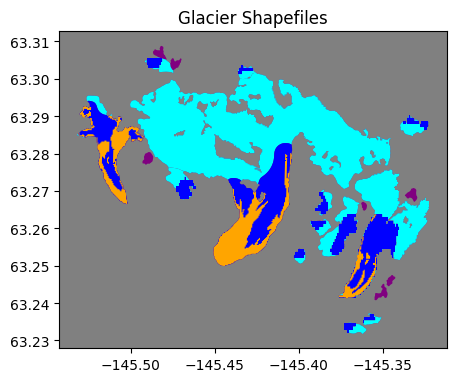

In [92]:
# Plot the shapefiles of each glacier type
# Note, the calculated ablation cells from the raster DEM will make some accumulation cells appear in the ablation zone
#  but since the resulting tiff will be on the resolution of the DEM, this will not be an issue in the final product
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_facecolor('gray')  # Set the background color to gray
rgi.plot(ax=ax, color='purple')
acc.plot(ax=ax, color='cyan')
abl.plot(ax=ax, color='blue')
deb.plot(ax=ax, color='orange')
ax.set_title('Glacier Shapefiles')
plt.show()

### d. Make tiff file of domain type
Types are:  
1. upland.
2. accumulation zone.
3. clean ablation zone.
4. debris ablation zone.
5. reserved for wetland, not yet implemented.
6. glacieret (may have debris may not).

In [93]:
# Define the glacier type array
glacier_type = np.ones(dem_data.shape, dtype=np.int16)  # default upland

# Overwrite for all glaciers
for i, glacier in rgi.iterrows():
    mask_array = geometry_mask([glacier.geometry], transform=dem_transform, invert=True, out_shape=dem_data.shape)
    glacier_type[mask_array] = 6

# If have zones, overwrite with zones (not glacieret)
for i, glacier in acc.iterrows():
    mask_array = geometry_mask([glacier.geometry], transform=dem_transform, invert=True, out_shape=dem_data.shape)
    glacier_type[mask_array] = 2
for i, glacier in abl.iterrows():
    mask_array = geometry_mask([glacier.geometry], transform=dem_transform, invert=True, out_shape=dem_data.shape)
    glacier_type[mask_array] = 3
for i, glacier in deb.iterrows():
    mask_array = geometry_mask([glacier.geometry], transform=dem_transform, invert=True, out_shape=dem_data.shape)
    glacier_type[mask_array] = 4

# Write the glacier type to a tiff file
output_file = glacier_dir / f"domain_{config['DOMAIN_NAME']}_glacier_type.tif"
meta.update(count=1, dtype='int16')
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(glacier_type, 1)

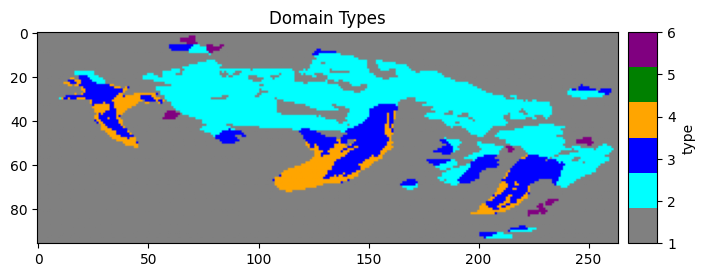

In [94]:
# plot the domain types
colors = ['gray', 'cyan', 'blue', 'orange', 'green', 'purple']
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(glacier_type, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=10)
ax.set_title('Domain Types')
cbar.set_label('type', fontsize=10)
plt.show()

### e. Make tiff file of glacier ID
ID will be RGI 6.0 ID, as a number (region number * 100000) + 5 digit ID (starts at 1 for each region). ID of 0 is no glacier.
This file will be used to make an initial glacier surface (from DEM) and glacier basal topography file for each glacier to use in flow calculations for area change. 

In [95]:
# glacier ID (for all glaciers, not glacierets)
glacier_id = np.zeros(dem_data.shape, dtype=np.int32) # default to 0 (no glacier), glacier IDs start at 1
col_id = np.zeros(1+len(big), dtype=np.int32)
j = 0
for i, glacier in big.iterrows():
    mask_array = geometry_mask([glacier.geometry], transform=dem_transform, invert=True, out_shape=dem_data.shape)
    id = int(glacier['RGIId'][9:]) + int(glacier['RGIId'][6:8]) * 100000
    glacier_id[mask_array] = id
    j += 1
    col_id[j] = id

# Write the glacier ID to a tiff file
output_file = glacier_dir / f"domain_{config['DOMAIN_NAME']}_glacier_id.tif"
meta.update(count=1, dtype='int32')
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(glacier_id, 1)

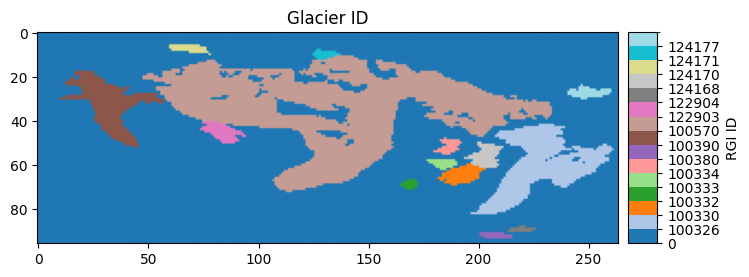

In [96]:
# plot the glacier ID
colors = plt.get_cmap('tab20', len(col_id)).colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=np.append(col_id, col_id[-1] + 1), ncolors=len(col_id))

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(glacier_id, cmap=cmap, norm=norm)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax, ticks=col_id)
cbar.ax.tick_params(labelsize=10)
ax.set_title('Glacier ID')
cbar.set_label('RGI ID', fontsize=10)
plt.show()

### f. Debris thickness data from Rounce et al., Geophysical Research Letters, 2021
Debris thickness in meters for all debris covered glaciers in RGI 6.0, one file per glacier. Debris was estimated by the authors with sub-debris melt and surface temperature estimates, as follows.

For glaciers with area >2 km2 a glacier sub-debris melt was estimated, assuming melt under debris is equivalent to the annual
climatic mass balance. The annual climatic mass balance was estimated from 2000-2018 by setting it equal to the elevation change plus the flux divergence. Elevation change was estimated with ASTER data (in relation to a DEM). Flux
divergence was estimated from surface velocity data from 1985 to 2018 (Gardner et al., 2019) and ice thickness
estimates (Farinotti et al., 2019), assuming only internal deformation and thus a ratio of column-average ice
velocity to surface velocity of 0.8. Then, an inversion for debri thickness from mass balance was performed over near-stagnant (<7.5 m yr−1) debris-covered areas.

Next, the distributed debris thickness was estimated for each debris-covered glacier grid cell from an inversion of surface
temperature, based on modeled surface temperatures and Landsat-8 surface temperature data. Each glacier with area >2 km2 had its inversion coefficients calibrated with the debris thickness estimates from its sub-debris melt inversion method. For the remaining debris-covered glaciers, the surface temperature inversion coefficients were calibrated with the nearest (>2 km2) glaciers' coefficients. 

The data footprint of the non-zero debris thickness of Rounce et al. is much smaller than the debris existance map of Herreid and Pellicciotti used to define domain type. A study by Herreid, Frontiers in Earth Science, 2021, showed the debris thickness method returned 0 cm for an area of measured thickness values of 4 cm. Furthermore, a previous study by Rounce et al., JGR Earth Surface, 2018, used any thickness below 2 cm as equivalent in an energy model to clean ice. Thus, we map all areas of thickness <4 cm to 4 cm so that all domain type debris areas will have a non-zero debris thickness after delineation.  

In [97]:
# https://n5eil01u.ecs.nsidc.org/HMA/HMA_DTE.001/2000.01.01/ 
# should go get this, but for now just use the ones downloaded from the website for the region
downloaded_dtk_dir = Path('/Users/amedin/Research/USask/Debris_thick')
min_thickness = 0.04 # minimum thickness of debris used in the model

# ID specific files, first check if the file exists, then reproject it
tiff_dir = glacier_dir / 'dtk_temp' # temporary directory for reprojected files
tiff_dir.mkdir(parents = True, exist_ok = True)
reprojected_files = []
for j, glacier in rgi.iterrows():
    dtk_tif_calib = downloaded_dtk_dir / f"region{str(int(RGI6_region[:2]))}/HMA_DTE_{str(int(RGI6_region[:2]))}.{glacier['RGIId'][9:]}_hdts_m.tif"
    dtk_tif_extrp = downloaded_dtk_dir / f"region{str(int(RGI6_region[:2]))}/HMA_DTE_{str(int(RGI6_region[:2]))}.{glacier['RGIId'][9:]}_hdts_m_extrap.tif"
    if dtk_tif_calib.exists():
        dtk_tif = dtk_tif_calib
    elif dtk_tif_extrp.exists():
        dtk_tif = dtk_tif_extrp
    else:
        continue
    with rasterio.open(dtk_tif) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        reprojected_file = os.path.join(tiff_dir, f'reprojected_{glacier['RGIId']}.tif')
        with rasterio.open(reprojected_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)
        reprojected_files.append(reprojected_file)

# open the reprojected files and merge them
src_files_to_mosaic = []
for reprojected_file in reprojected_files:
    src = rasterio.open(reprojected_file)
    src_files_to_mosaic.append(src)
mosaic, out_trans = merge(src_files_to_mosaic)

# set 1.e20 to 0 (no data value)
mosaic[mosaic == 1.e20] = 0
# set low values to min_thickness (minimum value)
mosaic[mosaic <= min_thickness] = min_thickness

# Update the metadata
out_meta = src.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": target_crs
})

# Close all the source files
for src in src_files_to_mosaic:
    src.close()

# Remove the temporary reprojected files
for reprojected_file in reprojected_files:
    os.remove(reprojected_file)

In [ ]:
# Subset the debris thickness mosaic to the bounding box of dem_data
dem_bounds = rasterio.transform.array_bounds(dem_data.shape[0], dem_data.shape[1], dem_transform)
bbox = box(*dem_bounds)

# Calculate the bounding box in the mosaic's coordinate system
mosaic_bounds = rasterio.transform.array_bounds(mosaic.shape[1], mosaic.shape[2], out_trans)
mosaic_bbox = box(*mosaic_bounds)

# Calculate the intersection of the bounding boxes
intersection = bbox.intersection(mosaic_bbox)

# Calculate the indices for the subset
minx, miny, maxx, maxy = intersection.bounds
row_start, col_start = ~out_trans * (minx, maxy)
row_stop, col_stop = ~out_trans * (maxx, miny)
row_start, row_stop = int(row_start), int(row_stop)
col_start, col_stop = int(col_start), int(col_stop)

# Subset the mosaic
mosaic_subset = mosaic[0][col_start:col_stop,row_start:row_stop]

# Create a new transform for the subset
mosaic_transform = from_bounds(minx, miny, maxx, maxy, mosaic_subset.shape[1], mosaic_subset.shape[0])

In [163]:
# Interpolate the debris thickness to the dem data resolution and keep a value if glacier_type is 4
deb_thickness = np.zeros(dem_data.shape, dtype=np.float32)  # default to 0 (no debris domain)
rows, cols = np.indices(dem_data.shape)
x_coords, y_coords = rasterio.transform.xy(dem_transform, rows, cols)
x_coords = np.array(x_coords).flatten()
y_coords = np.array(y_coords).flatten()

# Get the coordinates in the source raster's coordinate system
src_rows, src_cols = np.indices(mosaic_subset.shape)
src_x_coords, src_y_coords = rasterio.transform.xy(mosaic_transform, src_rows, src_cols)
src_x_coords = np.array(src_x_coords).flatten()
src_y_coords = np.array(src_y_coords).flatten()

# Create the points and values arrays for griddata
points = np.vstack([src_x_coords, src_y_coords]).T
values = mosaic_subset.flatten()

# Now interpolate the debris thickness to the dem data resolution
grid_x, grid_y = np.meshgrid(np.arange(dem_data.shape[1]), np.arange(dem_data.shape[0]))
interpolated_values = griddata(points, values, (x_coords, y_coords), method='nearest').reshape(dem_data.shape)
deb_thickness[glacier_type == 4] = interpolated_values[glacier_type == 4]

### g. Make tiff file of debris thickness data
This is non-zero if and only if the glacier type raster is debris. The raster data later be interpolated to the debri shape by HRU.

In [ ]:
# Write the debris thickness to a tiff file
output_file = glacier_dir / f"domain_{config['DOMAIN_NAME']}_debris_thickness.tif"
meta.update(count=1, dtype='float32')
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(deb_thickness, 1)

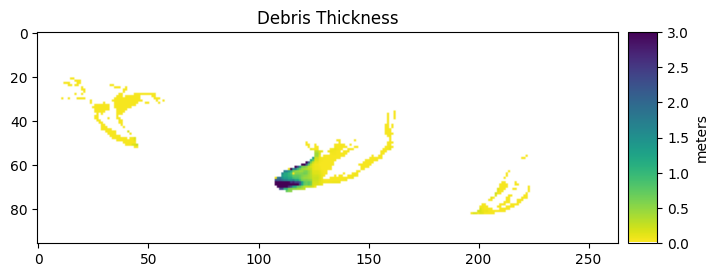

In [ ]:
# plot the debris thickness mosaic
viridis = plt.get_cmap('viridis')
viridis_r = viridis.reversed()

# Create a new colormap with 0 values set to white
colors = viridis_r(np.linspace(0, 1, 256))
colors[0] = [1, 1, 1, 1]  # Set the first color (0 value) to white
custom_cmap = LinearSegmentedColormap.from_list('custom_viridis_r', colors)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(deb_thickness, cmap=custom_cmap, norm=Normalize(vmin=0, vmax=np.max(deb_thickness)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=10)
ax.set_title('Debris Thickness')
cbar.set_label('meters', fontsize=10)  # Add label to colorbar
plt.show()

### h. Basal topography data from Milan, Nature Geoscience, 2022.
Glacier thickness in meters for RGI 6.0, in 5 tiff files. First, the authors used pairs of images of LANDSAT 8, Sentinel-1, and Sentinel-2 to map global glacier surface flow velocity in 2017 and 2018. Then, they computed the ice thickness on the basis of the glacier surface motion and slopes using the shallow-ice approximation (SIA). Since basal velocity is needed in the SIA and is unknown, basal velocity was estimated as a fraction of the surface velocity. The fraction value was based on the surface slope from a DEM. Parameters in the SIA were estimated regionally from measured thicknesses.

In [170]:
# https://www.sedoo.fr/theia-publication-products/?uuid=55acbdd5-3982-4eac-89b2-46703557938c
# should go get this, but for now just use the ones downloaded from the website for the region
downloaded_thick_dir = Path('/Users/amedin/Research/USask/Thickness_data')

# combine the thickness files for the region into one tiff file
tiff_dir = glacier_dir / 'tk_temp' # temporary directory for reprojected files
tiff_dir.mkdir(parents = True, exist_ok = True)

tk_tifs = []
# get all the thickness files for the region in the folder
files = downloaded_thick_dir.glob(f"RGI-{str(int(RGI6_region[:2]))}/THICKNESS_RGI-{str(int(RGI6_region[:2]))}.*tif")
for file in files:
    tk_tifs.append(file)

reprojected_files = []
for j, tk_tif in enumerate(tk_tifs):
    with rasterio.open(tk_tif) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        reprojected_file = os.path.join(tiff_dir, f'reprojected_{j}.tif')
        with rasterio.open(reprojected_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)
        reprojected_files.append(reprojected_file)

# open the reprojected files and merge them
src_files_to_mosaic = []
for reprojected_file in reprojected_files:
    src = rasterio.open(reprojected_file)
    src_files_to_mosaic.append(src)
mosaic, out_trans = merge(src_files_to_mosaic)

# Update the metadata
out_meta = src.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": target_crs
})

# Close all the source files
for src in src_files_to_mosaic:
    src.close()

# Remove the temporary reprojected files
for reprojected_file in reprojected_files:
    os.remove(reprojected_file)

In [171]:
# Subset the glacier thickness mosaic to the bounding box of dem_data
dem_bounds = rasterio.transform.array_bounds(dem_data.shape[0], dem_data.shape[1], dem_transform)
bbox = box(*dem_bounds)

# Calculate the bounding box in the mosaic's coordinate system
mosaic_bounds = rasterio.transform.array_bounds(mosaic.shape[1], mosaic.shape[2], out_trans)
mosaic_bbox = box(*mosaic_bounds)

# Calculate the intersection of the bounding boxes
intersection = bbox.intersection(mosaic_bbox)

# Calculate the indices for the subset
minx, miny, maxx, maxy = intersection.bounds
row_start, col_start = ~out_trans * (minx, maxy)
row_stop, col_stop = ~out_trans * (maxx, miny)
row_start, row_stop = int(row_start), int(row_stop)
col_start, col_stop = int(col_start), int(col_stop)

# Subset the mosaic
mosaic_subset = mosaic[0][col_start:col_stop,row_start:row_stop]

# Create a new transform for the subset
mosaic_transform = from_bounds(minx, miny, maxx, maxy, mosaic_subset.shape[1], mosaic_subset.shape[0])

In [180]:
# Interpolate the glacier thickness to the dem data resolution and keep a value if glacier_type is 2,3,4 (not upland, wetland, or glacieret)
thickness = np.zeros(dem_data.shape, dtype=np.float32)  # default to 0 (no glacier)
rows, cols = np.indices(dem_data.shape)
x_coords, y_coords = rasterio.transform.xy(dem_transform, rows, cols)
x_coords = np.array(x_coords).flatten()
y_coords = np.array(y_coords).flatten()

# Get the coordinates in the source raster's coordinate system
src_rows, src_cols = np.indices(mosaic_subset.shape)
src_x_coords, src_y_coords = rasterio.transform.xy(mosaic_transform, src_rows, src_cols)
src_x_coords = np.array(src_x_coords).flatten()
src_y_coords = np.array(src_y_coords).flatten()

# Create the points and values arrays for griddata
points = np.vstack([src_x_coords, src_y_coords]).T
values = mosaic_subset.flatten()

# Now interpolate the debris thickness to the dem data resolution
grid_x, grid_y = np.meshgrid(np.arange(dem_data.shape[1]), np.arange(dem_data.shape[0]))
interpolated_values = griddata(points, values, (x_coords, y_coords), method='nearest').reshape(dem_data.shape)
thickness[glacier_type == 2] = interpolated_values[glacier_type == 2]
thickness[glacier_type == 3] = interpolated_values[glacier_type == 3]
thickness[glacier_type == 4] = interpolated_values[glacier_type == 4]

### i. Make tiff file of thickness data
This raster will be used as the grid for each glacier for area change. Variables needed on the grid are surface elevation (initial will be the DEM values on the grid) and bottom elevation (DEM minus thickness, making sure all values are nonzero).

In [181]:
# Write the glacier thickness to a tiff file
output_file = glacier_dir / f"domain_{config['DOMAIN_NAME']}_glacier_thickness.tif"
meta.update(count=1, dtype='float32')
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(thickness, 1)

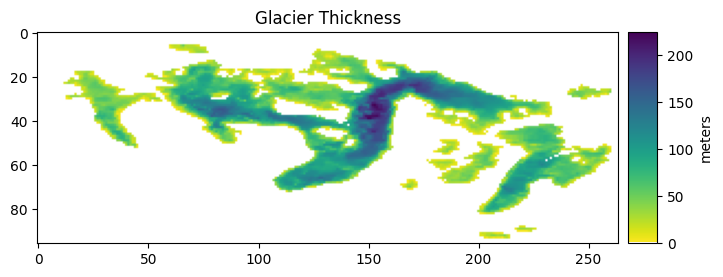

In [182]:
# plot the glacier thickness mosaic
viridis = plt.get_cmap('viridis')
viridis_r = viridis.reversed()

# Create a new colormap with 0 values set to white
colors = viridis_r(np.linspace(0, 1, 256))
colors[0] = [1, 1, 1, 1]  # Set the first color (0 value) to white
custom_cmap = LinearSegmentedColormap.from_list('custom_viridis_r', colors)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(thickness, cmap=custom_cmap, norm=Normalize(vmin=0, vmax=np.max(thickness)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=10)
ax.set_title('Glacier Thickness')
cbar.set_label('meters', fontsize=10)  # Add label to colorbar
plt.show()

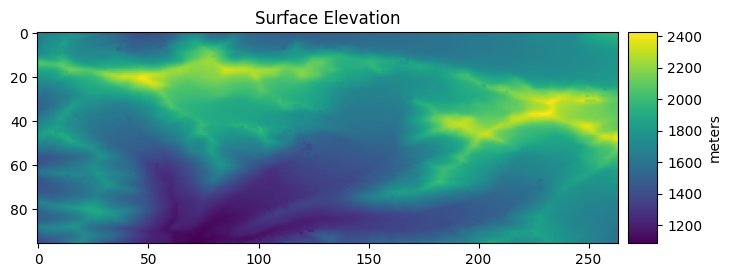

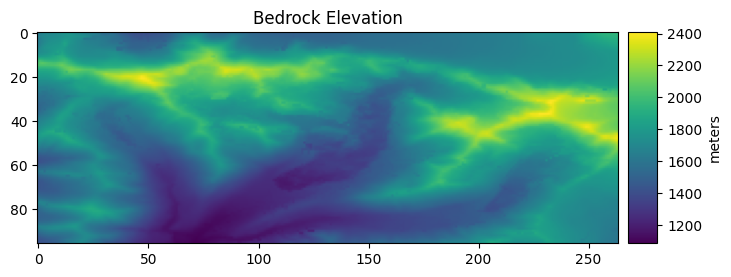

In [ ]:
# plot the surface elevations and bedrock elevations (glacier bottom) for comparison
# We may want to delineate the basin off the bedrock elevation, so it's good to see how it compares to the surface elevation
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(dem_data, cmap='viridis')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=10)
ax.set_title('Surface Elevation')
cbar.set_label('meters', fontsize=10)
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(dem_data-thickness, cmap='viridis')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=10)
ax.set_title('Bedrock Elevation')
cbar.set_label('meters', fontsize=10)
plt.show()

## Conclusion
Congratulations! You have successfully acquired the geospatial data we need to define our modelling domain and to estimate our model attributes.